Logistic Regression with a Neural Network mindset

Welcome to your first (required) programming assignment! You will build a logistic regression classifier to recognize cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

Instructions:

Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.
You will learn to:

Build the general architecture of a learning algorithm, including:
Initializing parameters
Calculating the cost function and its gradient
Using an optimization algorithm (gradient descent)
Gather all three functions above into a main model function, in the right order.

1 - Packages
First, let's run the cell below to import all the packages that you will need during this assignment.

numpy is the fundamental package for scientific computing with Python. 
h5py is a common package to interact with a dataset that is stored on an H5 file. 
matplotlib is a famous library to plot graphs in Python. 
PIL and scipy are used here to test your model with your own picture at the end. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset


In [31]:
# Loading the data (cat/non-cat)

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [32]:

print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes.shape)


(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
(2,)


We added "_orig" at the end of train_set_x and test_set_x , because we are going to preprocess them. After preprocessing we end up with train_set_x and test set_x.

We can visualize the image for diff index.

y = 0, its a 'non-cat' picture
0
0


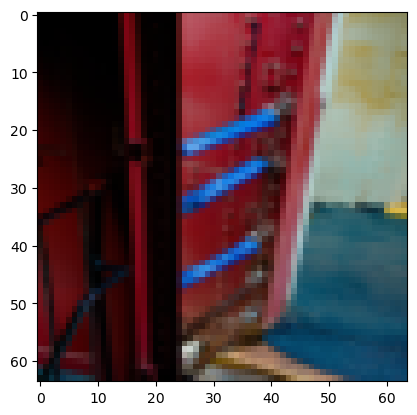

In [33]:
# Example of a picture

index = 45
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[0, index]) + ", its a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture")
print(train_set_y[0, index]) # gives you (x,y) entry from the array, (:,y) gives you an array with all rows for the y column.
print(np.squeeze(train_set_y[:, index])) # squeeze function is used when we want to remove single-dimensional entries from the shape of an array.


Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

Exercise: Find the values for: - m_train (number of training examples) - m_test (number of test examples) - num_px (= height = width of a training image) Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0]

In [25]:
m_train = train_set_x_orig.shape[0] #no of training examples
m_test = test_set_x_orig.shape[0]  # no of testing examples
num_px = train_set_x_orig.shape[1] # height and width of given image

print('Number of training samples : m_train ' + str(m_train))
print('Number of testing samples : m_test ' + str(m_test))
print("each image of size (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train set x shape: " + str(train_set_x_orig.shape))
print("train set y shape: " + str(train_set_y.shape))
print("test set x shape: " + str(test_set_x_orig.shape))
print("test set y shape: " + str(test_set_y.shape))

Number of training samples : m_train 209
Number of testing samples : m_test 50
each image of size (64, 64, 3)
train set x shape: (209, 64, 64, 3)
train set y shape: (1, 209)
test set x shape: (50, 64, 64, 3)
test set y shape: (1, 50)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px * num_px * 3, 1). After this, our training (and test) dataset 
is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

Exercise: Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px * num_px *3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b * c * d, a) is to use:

X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

In [34]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1] * train_set_x_orig.shape[2] * train_set_x_orig.shape[3], train_set_x_orig.shape[0])
# to make input as size of nx * m, where nx = W*H*D, m = no of samples
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1] * test_set_x_orig.shape[2] * test_set_x_orig.shape[3], test_set_x_orig.shape[0])

print("train set x shape: " + str(train_set_x_flatten.shape))
print("train set y shape: " + str(train_set_y.shape))
print("test set x shape: " + str(test_set_x_flatten.shape))
print("test set y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))


train set x shape: (12288, 209)
train set y shape: (1, 209)
test set x shape: (12288, 50)
test set y shape: (1, 50)
sanity check after reshaping: [17 71 49 38 70]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [28]:
train_set_x = train_set_x_flatten /255
test_set_x = test_set_x_flatten / 255

**What you need to remember:**
Common steps for pre-processing a new dataset are:

Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
"Standardize" the data

3 - General Architecture of the learning algorithm
It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why Logistic Regression is actually a very simple Neural Network!


[image](files://C:\Users\om_ar\OneDrive\Documents\khushbu\machine_learning\Coursera-deep-learning-specialization\Programming\C1W2\images\LogReg_kiank)

Mathematical expression of the algorithm:

For one example 
:
 
 
 

The cost is then computed by summing over all training examples:
 
 

Key steps: In this exercise, you will carry out the following steps: - Initialize the parameters of the model - Learn the parameters for the model by minimizing the cost
- Use the learned parameters to make predictions (on the test set) - Analyse the results and conclude

4 - Building the parts of our algorithm
The main steps for building a Neural Network are:

Define the model structure (such as number of input features)
Initialize the model's parameters
Loop:
Calculate current loss (forward propagation)
Calculate current gradient (backward propagation)
Update parameters (gradient descent)
You often build 1-3 separately and integrate them into one function we call model().

4.1 - Helper functions
Exercise: Using your code from "Python Basics", implement sigmoid(). As you've seen in the figure above, you need to compute 
 
 to make predictions. Use np.exp().

In [35]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    a = 1 + np.exp(-z)
    return 1/a

print(sigmoid(np.array([0, 2])))

[0.5        0.88079708]


4.2 - Initializing parameters
Exercise: Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [39]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros((dim, 1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

dim = 2
w, b = initialize_with_zeros(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


4.3 - Forward and Backward propagation
Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

Exercise: Implement a function propagate() that computes the cost function and its gradient.

Hints:

Forward Propagation:

You get X
You compute 
You calculate the cost function: 
 
Here are the two formulas you will be using:

 
 
 
 
 


In [41]:
# GRADED FUNCTION: propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    m = X.shape[1]
    #Forward propagation

    A = sigmoid(np.dot(w.T, X) + b)
    cost = np.sum(Y *(- np.log(A)) + (1-Y)*(-np.log(1-A)))/m

    #Backward propagation
    dw = np.dot(X, (A-Y).T)/m
    db = (np.sum(A-Y))/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {"dw" : dw, "db" : db}

    return grads, cost

w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


4.4 - Optimization
You have initialized your parameters.
You are also able to compute a cost function and its gradient.
Now, you want to update the parameters using gradient descent.
Exercise: Write down the optimization function. The goal is to learn 
 and 
 by minimizing the cost function 
. For a parameter 
, the update rule is 
, where 
 is the learning rate.

In [53]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate*dw
        b = b - learning_rate*db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0:
            print("cost after iteration %i : %f" %(i, cost))

    params = {"w" : w, "b" : b}
    grads = {"dw":dw, "db" : db}

    return params, grads, costs

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print(costs)
        

w = [[-0.08608643]
 [ 0.10971233]]
b = -0.1442742664803268
dw = [[0.12311093]
 [0.13629247]]
db = -0.14923915884638048
[0.8077356337712417]


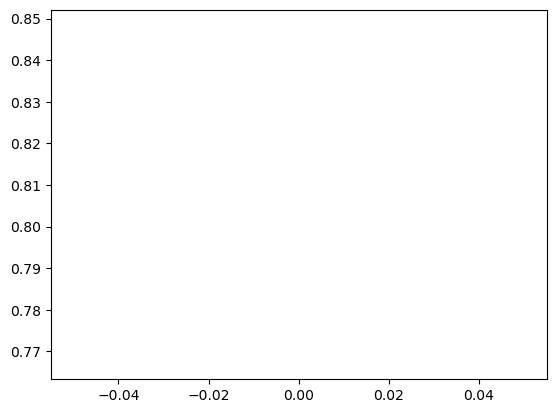

In [54]:
plt.plot(costs)

Exercise: The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function. There are two steps to computing predictions:

Calculate 

Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [55]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)   # A = (1, m)

    # using if else
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0

    # one line
    #for i in range(A.shape[1]):
    #    Y_prediction[0, i] = 1 if A[0, i] >= 0.5 else 0

    # vectorized
    #Y_prediction = (A >= 0.5) * 1.0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))



predictions = [[1. 1. 0.]]


5 - Merge all functions into a model
You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

Exercise: Implement the model function. Use the following notation: - Y_prediction_test for your predictions on the test set - Y_prediction_train for your predictions on the train set - w, costs, grads for the outputs of optimize()

In [56]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)





train accuracy: 91.38755980861244 %
test accuracy: 34.0 %


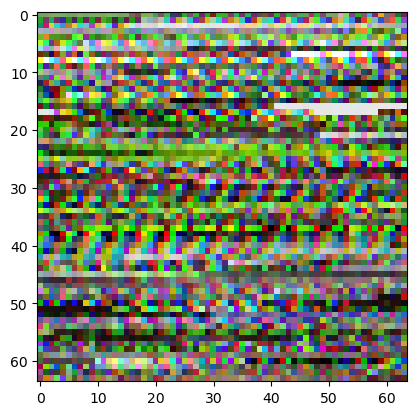

In [64]:
# Example of a picture that was wrongly classified.
index = 25
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
#print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture. ")

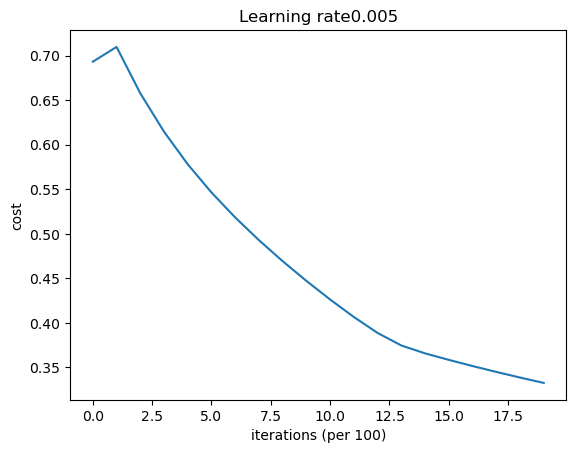

In [65]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per 100)')
plt.title("Learning rate" + str(d["learning_rate"]))
plt.show()

6 - Further analysis (optional/ungraded exercise)
Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate 
.

Choice of learning rate
Reminder: In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate 
 determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the learning_rates variable to contain, and see what happens.

learning rate is: 0.01
train accuracy: 71.29186602870814 %
test accuracy: 34.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 74.16267942583733 %
test accuracy: 34.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 66.02870813397129 %
test accuracy: 34.0 %

-------------------------------------------------------



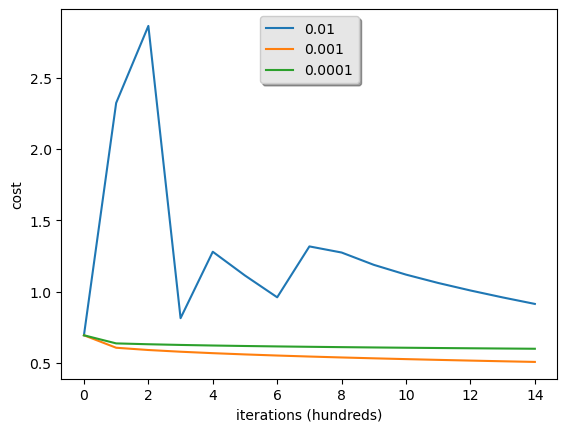

In [66]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Interpretation:

Different learning rates give different costs and thus different predictions results.
If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost).
A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
In deep learning, we usually recommend that you:
Choose the learning rate that better minimizes the cost function.
If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.)

7 - Test with your own image (optional/ungraded exercise)
Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that: 1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub. 2. Add your image to this Jupyter Notebook's directory, in the "images" folder 3. Change your image's name in the following code 4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [68]:
'''
my_image = "my_image.jpg"   # change this to the name of your image file 

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture. ")
'''

'\nmy_image = "my_image.jpg"   # change this to the name of your image file \n\n# We preprocess the image to fit your algorithm.\nfname = "images/" + my_image\nimage = np.array(ndimage.imread(fname, flatten=False))\nimage = image/255.\nmy_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T\nmy_predicted_image = predict(d["w"], d["b"], my_image)\n\nplt.imshow(image)\nprint("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a "" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "" picture. ")\n'

**What to remember from this assignment:** 1. Preprocessing the dataset is important. 2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model(). 3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!
Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include: - Play with the learning rate and the number of iterations - Try different initialization methods and compare the results - Test other preprocessings (center the data, or divide each row by its standard deviation)